In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf #library for linear regression
from mpl_toolkits.basemap import Basemap #library for mapping coordinates to map
#pd.options.display.mpl_style = 'default'
plt.style.use('default')

In [2]:
confirmed = pd.read_csv("Fires_Confirmed_2015.csv")
reported = pd.read_csv("Fires_Reported_2015.csv")
stations = pd.read_csv("Fire_Stations.csv")

In [5]:
# What are the common types of fire incidents that are reported but not confirmed?
common = reported.merge(confirmed, on = 'inci_no') #inner join of reported dataset and confirmed dataset

print ("1. Only {:.2f}% of fires reported in Minneapolis were actually confirmed.".format(float(len(confirmed))/len(reported)*100))

description = reported['descript'][~reported.inci_no.isin(common.inci_no)] #descript column of those cases that are reported but not confirmed
count_description = description.value_counts() #count values of a series

print ("2. The top 4 most occuring types of fires are:")
print (count_description.head(4))

1. Only 3.38% of fires reported in Minneapolis were actually confirmed.
2. The top 4 most occuring types of fires are:
EMS call, excluding vehicle accident with injury      7857
EMS-Arrive & Cancelled before PT Contact or No PT     5906
EMS-Asst medics-did NOT provide any BLS Treatment     3696
Dispatched & cancelled en route                       1292
Name: descript, dtype: int64


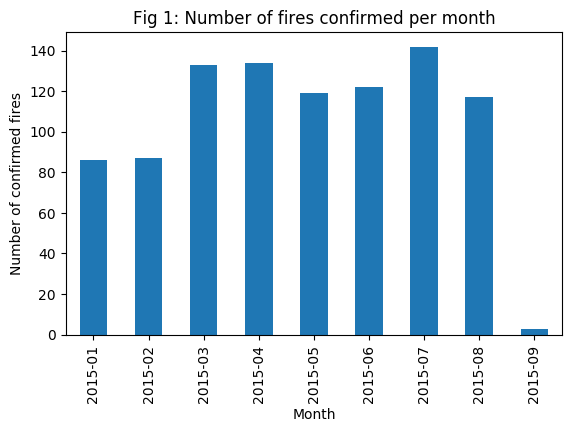

In [7]:
# What months have the most (confirmed) fires?
# combine column 5,6 together and parse as single date column with a format (YYYY-MM-MM HH:TT:SS),generating a new column 'alm_date_alm_time'
# 27th, 28th columns each is parsed as seperate date column
confirmed_date = pd.read_csv('Fires_Confirmed_2015.csv', parse_dates = [[4, 5], 25, 26], index_col = 'alm_date_alm_time')
# resample: frequency conversion/resampling of time series. Object must have a datetime-like index
monthly_count = confirmed_date.resample('M').size() #size() shows the number of cases falling into each time interval after resampling
#monthly_count is a pd.series, timestamped data(DatatimeIndex) can be converted to PeriodIndex-ed data using to_period(PeriodIndex)
monthly_count.index = monthly_count.index.to_period(freq = 'M')

plt.figure(1)
plt.gcf().subplots_adjust(bottom=0.25) # adjust the height of the graph to make room for the x_label
monthly_count.plot(kind='bar', title = 'Fig 1: Number of fires confirmed per month')
plt.xlabel('Month')
plt.ylabel('Number of confirmed fires')
plt.show()

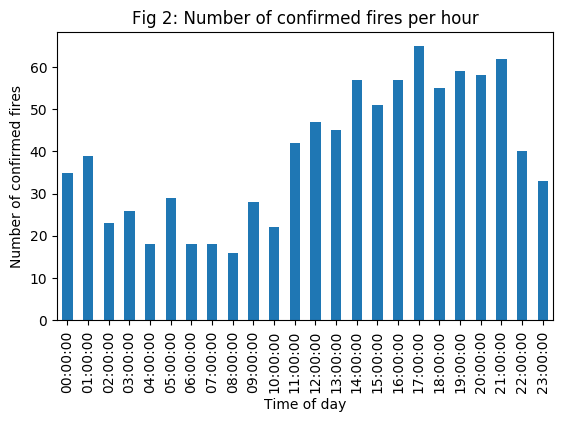

In [9]:
# What time of day has the most (confirmed) fires?
hourly = confirmed_date.resample('H').size()
#hourly.index.time: only pick the time part of the index ignoring the date
#sort time by no of confirmed fires(values), the default is sorted by index(time)
hourly_count = hourly.groupby(hourly.index.time).sum().sort_values(ascending = False)
hc = hourly.groupby(hourly.index.time).sum()

plt.figure(2)
plt.gcf().subplots_adjust(bottom=0.28)
hc.plot(kind='bar', title = 'Fig 2: Number of confirmed fires per hour')
plt.xlabel('Time of day')
plt.ylabel('Number of confirmed fires')
plt.show()

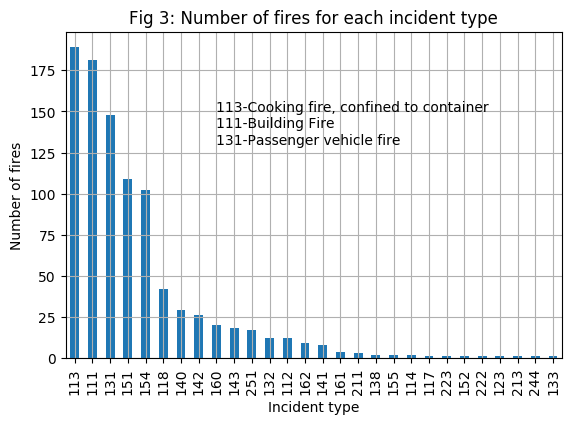

In [10]:
#what types of (confirmed) fire happen the most?
confirmed_date['Month'] = confirmed_date['StartDate'].dt.month #convert to datatime object and take month out
grouped = confirmed_date.groupby(['Month','inci_type']).size() #size() unfolds the groupby object
unst_grouped = grouped.unstack().fillna(0) #unstack: long format to wide format
yearround = unst_grouped.sum()#sum total for each inci_type

plt.figure(3)
plt.gcf().subplots_adjust(bottom=0.20)
yearround.sort_values(ascending = False).plot(kind='bar', grid=True, title='Fig 3: Number of fires for each incident type')

#add text to the graph: the location being annotated represented by the argument xy and the location of the text xytext
plt.annotate('113-Cooking fire, confined to container', xy=(8, 150), xytext=(8, 150))
plt.annotate('111-Building Fire', xy=(8, 140), xytext=(8, 140))
plt.annotate('131-Passenger vehicle fire', xy=(8, 130), xytext=(8, 130))

plt.xlabel('Incident type')
plt.ylabel('Number of fires')
plt.show()

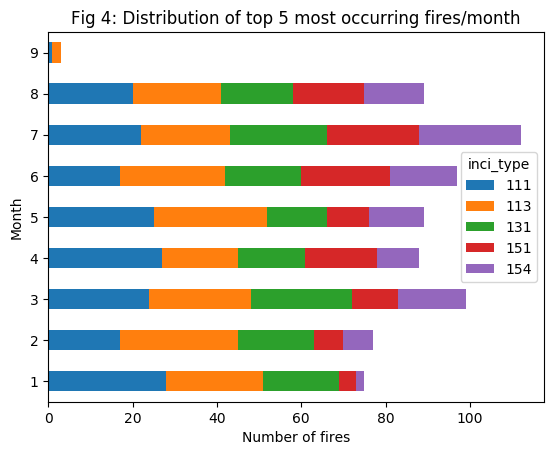

In [11]:
#for the top 5 types of confirmed fire with the most occurences, how do they distribute each month?
plt.figure(4)
#unst_grouped is a dataframe
unst_grouped.loc[:,[111,113,131,151,154]].plot(kind='barh', stacked=True, title='Fig 4: Distribution of top 5 most occurring fires/month')
plt.xlabel('Number of fires')
plt.show()

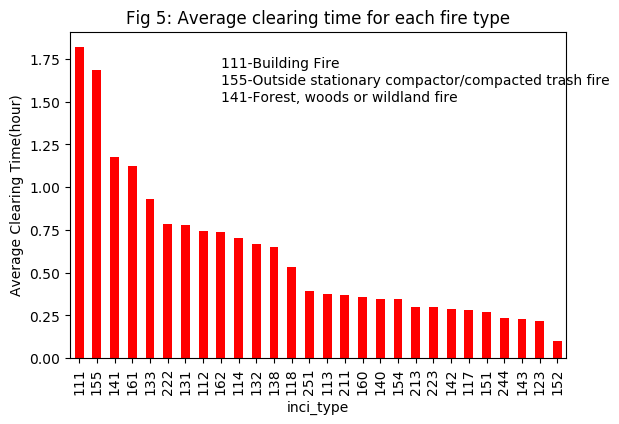

In [12]:
# How long does it take to put out the fire for each type of fire on average? 
# confirmed_date['EndDate'] and confirmed_date['StartDate'] are already datetime data type
confirmed_date['Clearing_time'] = confirmed_date['EndDate']-confirmed_date['StartDate']
confirmed_date['Clearing_time'] = confirmed_date['Clearing_time']/ np.timedelta64(1, 'h') #convert time(hh-tt-ss) to 1 hour unit

mean_inci_type = confirmed_date.groupby('inci_type').mean()['Clearing_time'].sort_values(ascending = False)

plt.figure(5)

plt.gcf().subplots_adjust(bottom=0.20)
mean_inci_type.plot(kind = 'bar',color = 'r', title = 'Fig 5: Average clearing time for each fire type')

plt.annotate('111-Building Fire', xy=(8, 1.7), xytext=(8, 1.7))
plt.annotate('155-Outside stationary compactor/compacted trash fire', xy=(8, 1.6), xytext=(8, 1.6))
plt.annotate('141-Forest, woods or wildland fire', xy=(8, 1.5), xytext=(8, 1.5))

plt.ylabel('Average Clearing Time(hour)')
plt.show()

In [13]:
# Which type of fire takes the longest time to put out?
# use inci_no to find the incident type description, strip() is needed to strip the white space out
type_longest = confirmed_date[confirmed_date['inci_type']== mean_inci_type.head(1).index.tolist()]['descript'].head(1).str.strip().tolist()
print ('3. {} takes the longest time to put out.'.format(type_longest))

3. ['Building fire'] takes the longest time to put out.


In [14]:
# What kind of weather metrics can we use to predict a high likelihood of fire?
weather = pd.read_csv('MSP_weather_data.csv',parse_dates = [0],index_col = 'Date')

fire_confirmed = pd.read_csv('Fires_Confirmed_2015.csv', parse_dates = [4], index_col = 'alm_date')
fire_confirmed = fire_confirmed.reset_index()
#rename alm_date to Date
fire_confirmed = fire_confirmed.rename(columns = {'alm_date':'Date'})
#after grouping, Date column has become index
weather_count = fire_confirmed.groupby('Date').count()
#concat: join by index
weather_fire = pd.concat([weather_count, weather], axis = 1).fillna(0)
#Ordinary Least Squares: here inci_no has become the number of fires on that day,all columns are the same after groupby
mod = smf.ols("inci_no ~ max_temperaturef + min_humidity + cloudcover", weather_fire).fit()

b1 = mod.params['max_temperaturef']
b2 = mod.params['min_humidity']
b3 = mod.params['cloudcover']
intercept = mod.params['Intercept']

print (mod.summary())
print ('4. The fire prediction model is: No of fire confirmed a day = {0:.2f} + {1:.2f}*max_temperaturef {2:.2f}*min_humidity {3:.2f}*cloudcover.'.format(intercept, b1, b2, b3))

                            OLS Regression Results                            
Dep. Variable:                inci_no   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     13.62
Date:                Thu, 13 Jul 2017   Prob (F-statistic):           3.08e-08
Time:                        20:16:03   Log-Likelihood:                -550.54
No. Observations:                 245   AIC:                             1109.
Df Residuals:                     241   BIC:                             1123.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.5483      0.671  

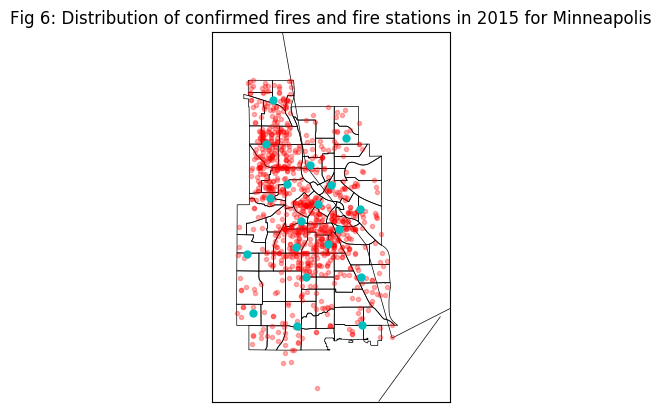

In [15]:
# Plot of confirmed fires and fire stations to identify the best location for next fire station

plt.figure(6)
plt.title('Fig 6: Distribution of confirmed fires and fire stations in 2015 for Minneapolis')

# set the extent of the map: define the map bounding box in geographical coordinates:
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon are the lat/lon values of the lower left and upper right corners of the map.
# set the bounding box giving the center point in geographical coordinates: lat_0,lon_0/ resolution='i':intermediate
map_mn = Basemap(llcrnrlon=-93.35,llcrnrlat=44.86,urcrnrlon=-93.15,urcrnrlat=45.08,
resolution='i', projection='tmerc', lat_0=44.97, lon_0=-93.27)

#map geographical scope to the existing map(Neighborhoods.shp) through map_mn
map_mn.readshapefile('C:/Users/Hanyuan CHI/Desktop/1_Carlson_MSBA/Summer/1_msba6310 Python/Project/code&raw data/Neighborhoods', 'neighborhoods')

#get lat and lon of confirmed fires
lat = confirmed['latitude'].values
lon = confirmed['longitude'].values

#convert geographical coordinates to coordinates in the map through map_mn
x,y = map_mn(lon,lat)

#alpha:color degree
map_mn.plot(x,y,'ro',markersize=3,alpha=.3)

slat = stations['Y'].values
slon = stations['X'].values

x,y = map_mn(slon,slat)
map_mn.plot(x,y,'co',markersize=5)

map_mn.drawrivers()

plt.show()